# DeepDream

DeepDream is an experiemnt that visualizes the patterns learned by a neural network. DeepDream over-interprets, and enhaces the patterns it sees in an image. 
How it does it (via "inceptionism"):
- forward an image through the network
- calculate the gradients of the imge w.r.t. the activations of a particular layer

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

## Load Data

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

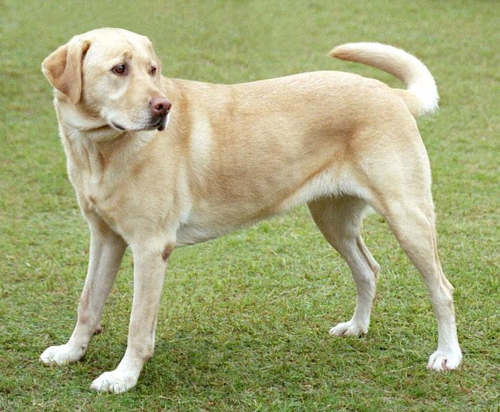

In [6]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))


## Preprocess

Prepare a pre-trained image classification model like `InceptionV3` which is similar to the model originally used in DeepDream. (any model works though).

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 29s 0us/step


## Build Model

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly excited the layers. The complexity of the features incorporated depends on layers chosen by you (e.g. lower layers produce strokes or simple patterns, and deeper layers give sophisticated features in images, or whole objects)

The InceptionV3 architecture is quite large. For DeepDream, the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named `mixed0` through `mixed10`. 

Using different layers will result in different dream-like images. Deep layers respond to higher-level features, while earlier layers respond to simple features. 

In [8]:
# maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### Calculate Loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers don't outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you'll maximize the loss via gradient descent. 

In [9]:
def calc_loss(img, model):
    # pass forward the image through the model to retrieve the activations
    # convert the image into a batch of size 1
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_mean(losses)

### Gradient Ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients w.r.t. the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this (below) is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retracted for different image sizes or `step / step_size` values.

In [10]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # this needs gradients relative to 'img'
                # 'GradientTape' only watches 'tf.Variable's by default
                tape.watch(img)
                loss = calc_loss(img, self.model)
                
            # calculate the gradient of the loss w.r.t. the pixels of the input image
            gradients = tape.gradient(loss, img)
            
            # normalize gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            # in gradient ascent, the loss is maximized so that the input image increasingly "excites" the layers.
            # you can update the image by directly adding the gradients (b/c they're the same shape.)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img

In [11]:
deepdream = DeepDream(dream_model)

### Main Loop

In [14]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # convert from uint8 to the range expected by the model
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
            
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print(f"Step {step}, loss {loss}")
        
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    
    return result

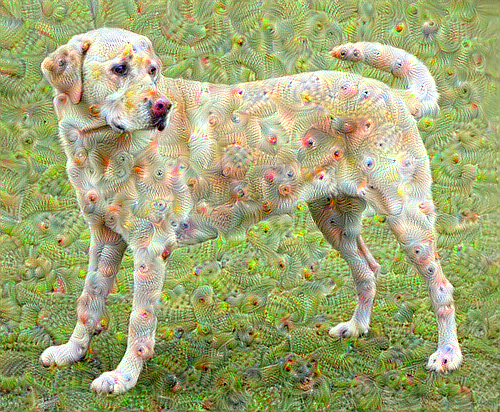

In [15]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

## Evaluate

The few issues from base model:
- The output is noisy (this could be addressed with `tf.image.total_variation` loss).
- The image is low resolution
- the patterns appear like theire all happening at the same granularity

One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scles to be incorporated into patterns at higher scales and filled in with additional detail. 

Let's perform the previous gradient ascent approach, then increase the size of the image (referred to as an `octave`), then repeat this process for multiple octaves.

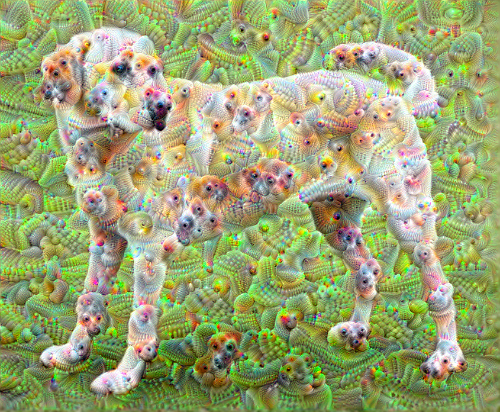

319.75206184387207

In [18]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape  = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)
    
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
show(img)

end = time.time()
end - start

### Scale up with tiles

As the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves. 

To avoid this issue you can:
- split the image into tiles and compute the gradient for each tile - apply random shifts to the image bfore each tiled computation prevents tile seams from appearing

In [19]:
def random_roll(img, maxroll):
    # randomly shift the image to avoid tiled boundaries
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0, 1])
    return shift, img_rolled

Below is the tiled equivalent of the `deepdream` class defined earlier.

In [20]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[2], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.int32)
        )
    )
    
    def __call__(self, img, img_size, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)
        
        # initialize the image gradients to zero
        gradients = tf.zeros_like(img_rolled)
        
        # skip the last tile, unless there's only one tile
        xs = tf.range(0, img_size[1], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
            
        ys = tf.range(0, img_size[0], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])
            
        for x in xs:
            for y in ys:
                # calculate the gradients for this tile
                with tf.GradientTape() as tape:
                    # this needs gradients relative to `img_rolled`
                    # 'GradientTape' only watches 'tf.Variable's by default
                    tape.watch(img_rolled)
                    
                    # extract a tile out of the image
                    img_tile = img_rolled[y:y + tile_size, x:x + tile_size]
                    loss = calc_loss(img_tile, self.model)
                    
                # update the image gradients for this tile
                gradients = gradients + tape.gradient(loss, img_rolled)
                
            # undo the random shift applied to the image and its gradients
            gradients = tf.roll(gradients, shift=-shift, axis=[0, 1])
            
            # normalize the gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            return gradients

In [21]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation

In [24]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-2, 3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.utils.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    
    for octave in octaves:
        # scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32) * (octave_scale**octave)
        new_size = tf.cast(new_size, tf.int32)
        img = tf.image.resize(img, new_size)
        
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img, new_size)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)
            
            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print(f"Octave {octave}, Step {step}")
    result = deprocess(img)
    return result

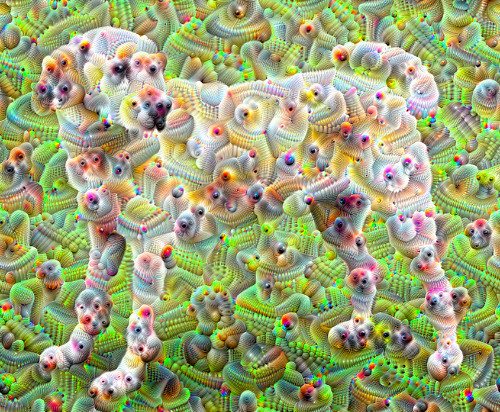

In [25]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
show(img)